In [24]:
# Genearal usage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import warnings

# dimention reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score

<img src="raw/Traveling.png" width="600" height="350">

In [2]:
train_data = pd.read_csv('raw/train_data.csv')
test_data = pd.read_csv('raw/test_data.csv')

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task1</b> <h style="font-size: 18px;"> : Conduct a preliminary analysis of the dataset. Visualize the data and report any observations that might be relevant to your tasks. </h>
<hr style="border-top: 0.5px solid #b;">

In [3]:
train_data.describe()

,travel_mode,TrvlTime_number,Age,indiv_trvl_frequency,HHVeh,HHsize
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.789750,1044.952107,45.013750,28.658250,1.804000,3.695250
std,0.407537,1424.072973,14.929259,20.390105,0.910105,1.710733
min,0.000000,6.000000,16.000000,3.000000,0.000000,1.000000
25%,1.000000,340.078000,34.000000,15.000000,1.000000,2.000000
50%,1.000000,660.000000,44.000000,24.000000,2.000000,4.000000
75%,1.000000,1318.000000,56.000000,36.000000,2.000000,5.000000
max,1.000000,34350.000000,89.000000,192.000000,7.000000,13.000000


In [4]:
test_data.describe()

,travel_mode,TrvlTime_number,Age,indiv_trvl_frequency,HHVeh,HHsize
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.783000,1108.739891,44.355000,28.402000,1.767000,3.601000
std,0.412409,1667.569592,14.577087,22.071782,0.949533,1.677681
min,0.000000,19.999980,16.000000,3.000000,0.000000,1.000000
25%,1.000000,368.750000,33.000000,14.000000,1.000000,2.000000
50%,1.000000,699.008500,43.000000,22.000000,2.000000,4.000000
75%,1.000000,1370.890000,55.000000,35.250000,2.000000,5.000000
max,1.000000,37764.000000,94.000000,192.000000,7.000000,12.000000


Overall statistics looks very similar which indicates a successful random sampling between train and test dataset.

In [5]:
train_data.dtypes

travel_mode               int64
TrvlTime_number         float64
Age                       int64
indiv_trvl_frequency      int64
HHVeh                     int64
HHsize                    int64
dtype: object

All of the columns are numeric and thus we can feed the data to pca model without preprocessing other types of data such as object or datetime.

array([[<Axes: title={'center': 'travel_mode'}>,
        <Axes: title={'center': 'TrvlTime_number'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'indiv_trvl_frequency'}>],
       [<Axes: title={'center': 'HHVeh'}>,
        <Axes: title={'center': 'HHsize'}>]], dtype=object)

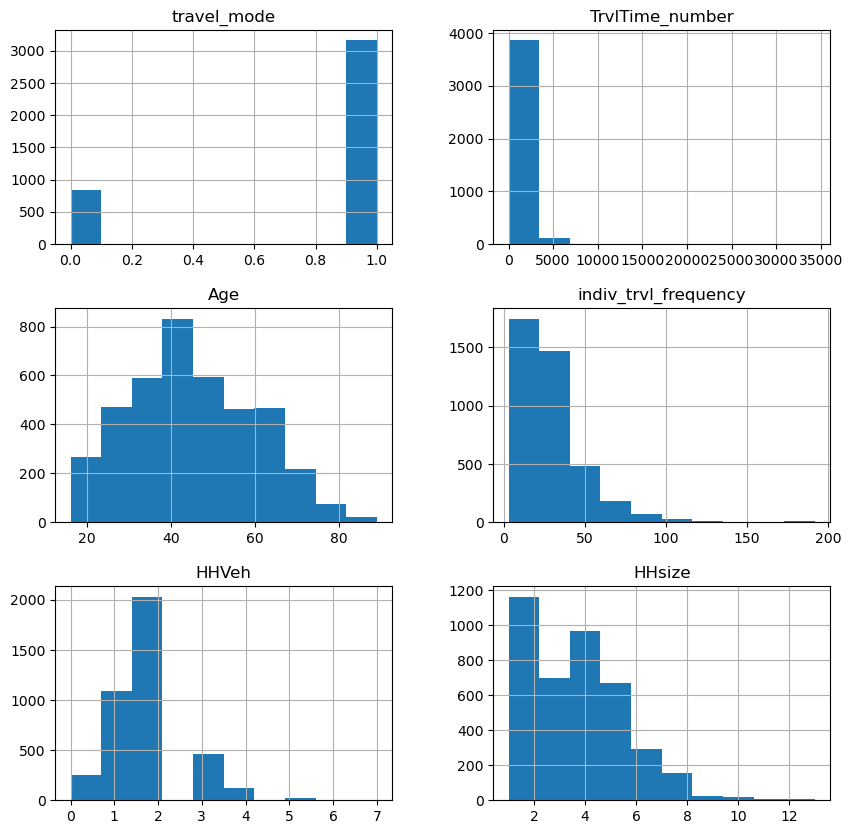

In [6]:
train_data.hist(figsize = (10,10))

There are reletively large gaps in scale of each variable.  Standardization would be necessary before conducting pca/clustering.

In [7]:
train_data.corr()

,travel_mode,TrvlTime_number,Age,indiv_trvl_frequency,HHVeh,HHsize
travel_mode,1.000000,0.158679,0.104993,0.233447,0.377664,0.005274
TrvlTime_number,0.158679,1.000000,0.022430,0.007686,0.108580,-0.034190
Age,0.104993,0.022430,1.000000,-0.004295,0.022688,-0.325799
indiv_trvl_frequency,0.233447,0.007686,-0.004295,1.000000,0.594961,0.185159
HHVeh,0.377664,0.108580,0.022688,0.594961,1.000000,0.180699
HHsize,0.005274,-0.034190,-0.325799,0.185159,0.180699,1.000000


There are a few autocorrelated variables such as Age and HHsize, or HHVeh and infiv_trvl_frequency.  <br>
This can be taken care of by conducting PCA before clustering.

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task2</b> <h style="font-size: 18px;">  : Data Preprocessing: Standardize the dataset and use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset (nominate an appropriate number of principal components to represent at least 90% variation in the data). Note that the dataset is already split into a training set and a test set. You should use them directly. </h>
<hr style="border-top: 0.5px solid #b;">

##### 1) Standardize the dataset

Introduce the standardize function which implements the following operations to the input dataframe(train_data or test_data)
- change the df shape so it only includes the columns with independent variables
- initiate StandardScaler and fit&transform the reshaped df
- convert back the standardized arrays into pandas df
- insert back the dependent variable (travel_mode) to the df
- return df

In [8]:
def standardize(df):
    df_stmd = df.drop('travel_mode', axis = 1)
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df_stmd)
    scaled_df = pd.DataFrame(scaled_df, columns = df_stmd.columns)
    scaled_df['travel_mode'] = df['travel_mode']
    scaled_df.insert(0, 'travel_mode', scaled_df.pop('travel_mode'))
    return scaled_df

apply standardize function to both data

In [9]:
train_data_std = standardize(train_data)
test_data_std = standardize(test_data)

check if the transformation was successful be looking at the head of df and look at mean and sd (whether they are around 0 and 1 respectively)

In [10]:
train_data_std.head(3)

,travel_mode,TrvlTime_number,Age,indiv_trvl_frequency,HHVeh,HHsize
0,0,-0.61661,0.066070,1.243001,1.314298,0.76278
1,1,-0.10180,0.133061,-0.228485,1.314298,0.76278
2,1,0.13347,-0.469858,-0.424683,0.215387,0.76278


In [11]:
train_data_std.describe()

,travel_mode,TrvlTime_number,Age,indiv_trvl_frequency,HHVeh,HHsize
count,4000.000000,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03
mean,0.789750,1.225686e-16,-1.065814e-16,6.217249e-17,-4.884981e-17,-1.332268e-17
std,0.407537,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00
min,0.000000,-7.296550e-01,-1.943658e+00,-1.258525e+00,-1.982437e+00,-1.575691e+00
25%,1.000000,-4.950324e-01,-7.378214e-01,-6.699307e-01,-8.835250e-01,-9.910731e-01
50%,1.000000,-2.703515e-01,-6.791206e-02,-2.284850e-01,2.153867e-01,1.781622e-01
75%,1.000000,1.917613e-01,7.359792e-01,3.601094e-01,2.153867e-01,7.627799e-01
max,1.000000,2.339010e+01,2.946680e+00,8.011836e+00,5.709945e+00,5.439721e+00


##### 2) Dimention Reduction through PCA

Introduce the standardize function which implements the following operations to the input dataframe(train_data_std or test_data_std)
1. conducting PCA
2. Calculate the variance ratio of each PC
3. Drawing screeplot to visualize 2.
4. calculate the contribution of each PC towards the original variables
5. calculate the predicted result per PC, draw histogram and return data in dataframe format.

In [12]:
def executePCA(df):
    # conduct PCA
    df_pca = df.drop('travel_mode', axis = 1)
    pca = PCA(n_components = df_pca.shape[1])
    pca.fit(df_pca)
    pca_pred = pca.transform(df_pca)

    # calculate the variance ratio of each PC
    variance_ratio = [round(variance_ratio, 5) for variance_ratio in pca.explained_variance_ratio_]
    print('variance_ratio of each PC:', variance_ratio)

    # scree plot
    plt.figure()
    plt.figure()
    plt.plot([0] + list(range(1, len(variance_ratio) + 1)), [0] + list(np.cumsum(pca.explained_variance_ratio_)))
    plt.hlines(y = 0.90, xmin = 0, xmax = len(variance_ratio) , color = 'r', linewidth = 0.7)
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.show()

    # contribution by PC
    contribution = pd.DataFrame(pca.components_)
    PCindex = ['PC' + str(i + 1) for i in range(df_pca.shape[1])]
    contribution.index = PCindex
    contribution.columns = [df_pca.columns[0:]]
    print(contribution)

    # predition
    pca_pred_df = pd.DataFrame(pca_pred,
                           columns = ["PC{}".format(x + 1) for x in range(len(df_pca.columns))]
                           )
    
    # draw histogram
    pca_pred_df.hist(figsize = (8,7))
    
    return pca_pred_df


Conduct PCA for train data

variance_ratio of each PC: [0.34276, 0.2539, 0.19762, 0.12658, 0.07914]


<Figure size 640x480 with 0 Axes>

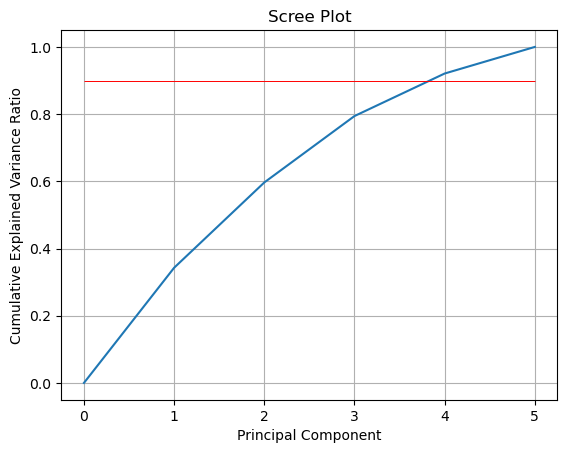

    TrvlTime_number       Age indiv_trvl_frequency     HHVeh    HHsize
PC1        0.079706 -0.161969             0.635794  0.637249  0.396350
PC2        0.246739  0.711544             0.221017  0.274890 -0.555349
PC3        0.956332 -0.218188            -0.183350 -0.028408  0.058308
PC4        0.062927  0.646430            -0.193496 -0.103336  0.728045
PC5        0.119319  0.044639             0.689826 -0.711944  0.032340


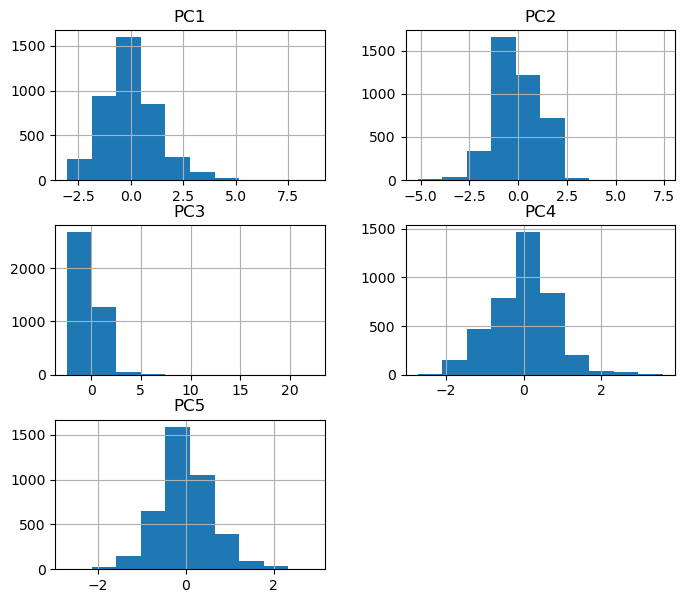

In [13]:
pca_pred_train = executePCA(train_data_std)

Possible interpretation of each PC:
- PC1: Frequent travelers who own more vehicles.
- PC2: Older people with small householdsize.
- PC3: Travelers who takes more time when traveling
- PC4: Older people with large householdsize.

In [14]:
# check data structure
pca_pred_train.head()

,PC1,PC2,PC3,PC4,PC5
0,1.870306,0.107272,-0.824864,0.182916,-0.124208
1,0.964927,-0.043260,-0.077355,0.543343,-1.074861
2,0.256313,-0.759655,0.346382,0.319924,-0.426681
3,0.171103,0.217885,-0.259142,0.343172,-0.104724
4,1.571588,-0.169481,0.608464,-1.578547,-0.299968


Drop PC5 as PC1 to PC4 together explains more than 90% of the variables.

In [15]:
pca_pred_train = pca_pred_train.drop('PC5', axis = 1)

sanity check with linear regression that PC1 - PC4 would be sufficient to explain the dependent variable.

In [16]:
reg = LogisticRegression()
reg.fit(pca_pred_train, train_data['travel_mode'])
print('The estimated coefficients: ', reg.coef_)
print('The estimated intercept (e.g., $\beta_0$): ', reg.intercept_)
print('R^2 for test: %.2f' % reg.score(pca_pred_train, train_data['travel_mode']))

The estimated coefficients:  [[ 0.96639532  0.8831797   1.02343372 -0.00511068]]
The estimated intercept (e.g., eta_0$):  [1.93156002]
R^2 for test: 0.84


Conduct PCA for test data

variance_ratio of each PC: [0.35617, 0.25076, 0.19475, 0.13122, 0.06709]


<Figure size 640x480 with 0 Axes>

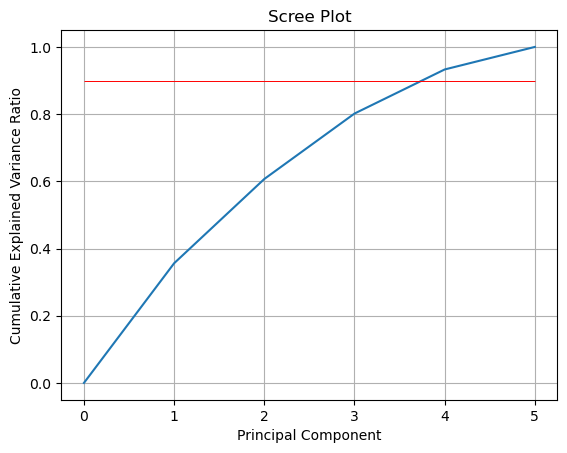

    TrvlTime_number       Age indiv_trvl_frequency     HHVeh    HHsize
PC1        0.009266 -0.017310             0.650959  0.660851  0.373018
PC2        0.326136  0.737277             0.150936  0.173725 -0.545066
PC3        0.942204 -0.248020            -0.117407 -0.012340  0.191836
PC4       -0.016801  0.625971            -0.263940 -0.130839  0.721869
PC5        0.074286  0.052636             0.685581 -0.718209  0.076582


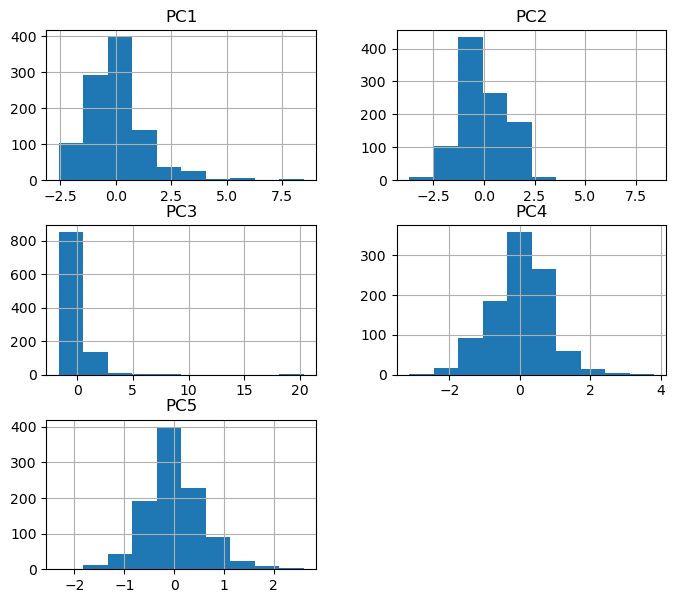

In [17]:
pca_pred_test = executePCA(test_data_std)

In [18]:
pca_pred_test = pca_pred_test.drop('PC5', axis = 1)

In [19]:
reg = LogisticRegression()
reg.fit(pca_pred_test, test_data['travel_mode'])
print('The estimated coefficients: ', reg.coef_)
print('The estimated intercept (e.g., $\beta_0$): ', reg.intercept_)
print('R^2 for test: %.2f' % reg.score(pca_pred_test, test_data['travel_mode']))

The estimated coefficients:  [[ 1.02581852  0.67808653  0.24311826 -0.22949893]]
The estimated intercept (e.g., eta_0$):  [1.77368572]
R^2 for test: 0.84


<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task3</b> <h style="font-size: 18px;">  : Model Building and Evaluation: Implement the clustering algorithms and evaluate their performance. You should report the accuracy and precision (for the prediction of car mode) of each model on the test set. </h>
<hr style="border-top: 0.5px solid #b;">

##### 1) K-Means


Given the clustering result varies quite a lot for each run, I conduct each clustering for 40 runs and extract the one with the score (accurary + precision)

for trial data

In [20]:
# ignore warnings message
warnings.filterwarnings("ignore")

# Number of runs
n_runs = 40

# Initialize varaiables
best_kmeans = None
best_score = -1 

# Perform K-means multiple times and reserve the one with the highest accuracy
for _ in range(n_runs):
    kmeans = KMeans(n_clusters=2)
    kmeans_train_preds = kmeans.fit_predict(pca_pred_train)
    
    kmeans_accuracy = accuracy_score(train_data['travel_mode'], kmeans_train_preds)
    kmeans_precision = precision_score(train_data['travel_mode'], kmeans_train_preds)
    kmean_total_score =  kmeans_accuracy + kmeans_precision

    if  kmean_total_score > best_score:
        best_score = kmean_total_score
        best_kmeans = kmeans

# Predict with the best K-means model
kmeans_train_preds = best_kmeans.fit_predict(pca_pred_train)

for test data

In [21]:
kmeans_test_preds = best_kmeans.fit_predict(pca_pred_test)

store both results into one dataframe

In [22]:
kmean_train_df = pd.DataFrame({'y': train_data['travel_mode'],
                               'y_hat' : kmeans_train_preds})
kmean_test_df = pd.DataFrame({'y': test_data['travel_mode'],
                              'y_hat' : kmeans_test_preds}
                              )

Result: Trial

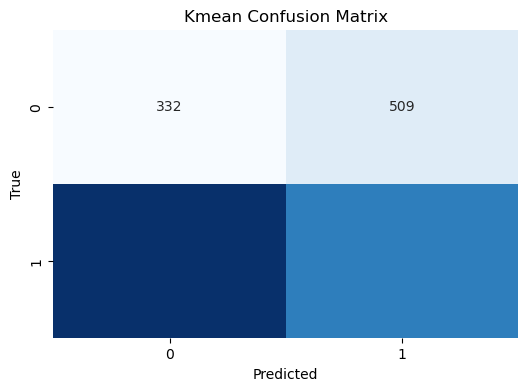

Accuracy: 0.42
Precision: 0.73


In [25]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(kmean_train_df['y'], kmean_train_df['y_hat'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Kmean Confusion Matrix')
plt.show()

# Evaluate K-means
kmeans_accuracy = accuracy_score(train_data['travel_mode'], kmeans_train_preds)
kmeans_precision = precision_score(train_data['travel_mode'], kmeans_train_preds)

print(f"Accuracy: {kmeans_accuracy:.2f}")
print(f"Precision: {kmeans_precision:.2f}")

Result: Test

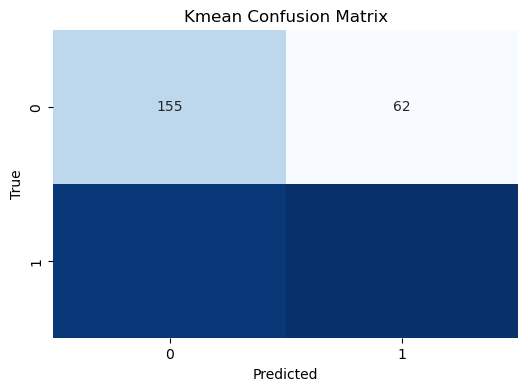

Accuracy: 0.55
Precision: 0.86


In [27]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(kmean_test_df['y'], kmean_test_df['y_hat'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Kmean Confusion Matrix')
plt.show()

# Evaluate K-means
kmeans_accuracy = accuracy_score(test_data['travel_mode'], kmeans_test_preds)
kmeans_precision = precision_score(test_data['travel_mode'], kmeans_test_preds)

print(f"Accuracy: {kmeans_accuracy:.2f}")
print(f"Precision: {kmeans_precision:.2f}")

##### 2) Gaussian Mixture

for trial data

In [28]:
# Initialize varaiables
best_gmm = None
best_score = -1 

# Perform K-means multiple times and reserve the one with the highest accuracy
for _ in range(n_runs):
    gmm = GaussianMixture(n_components=2)
    gmm_train_preds = gmm.fit_predict(pca_pred_train)
    
    gmm_accuracy = accuracy_score(train_data['travel_mode'], gmm_train_preds)
    gmm_precision = precision_score(train_data['travel_mode'], kmeans_train_preds)
    gmm_total_score =  gmm_accuracy + gmm_precision
    
    if  gmm_total_score > best_score:
        best_score = gmm_total_score
        best_gmm = gmm

# Predict with the best K-means model
gmm_train_preds = best_gmm.fit_predict(pca_pred_train)

for test data

In [29]:
gmm_test_preds = best_gmm.fit_predict(pca_pred_test)

In [30]:
gmm_train_df = pd.DataFrame({'y': train_data['travel_mode'],
                             'y_hat' : gmm_train_preds})
gmm_test_df = pd.DataFrame({'y': test_data['travel_mode'],
                            'y_hat' : gmm_test_preds})

In [31]:
gmm_train_df.head()

,y,y_hat
0,0,0
1,1,0
2,1,0
3,1,0
4,1,1


Result: Trial

Accuracy: 0.40
Precision: 0.95


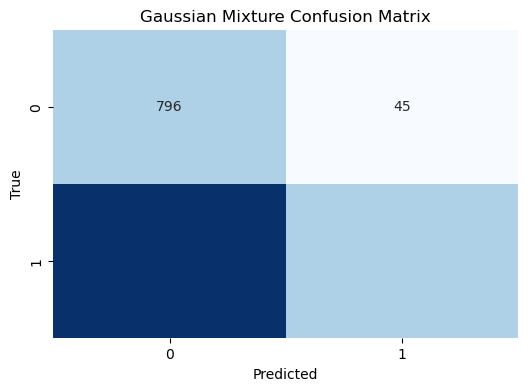

In [32]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(gmm_train_df['y'], gmm_train_df['y_hat'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gaussian Mixture Confusion Matrix')
plt.show

# Evaluate K-means
gmm_accuracy = accuracy_score(train_data['travel_mode'], gmm_train_preds)
gmm_precision = precision_score(train_data['travel_mode'], gmm_train_preds)

print(f"Accuracy: {gmm_accuracy:.2f}")
print(f"Precision: {gmm_precision:.2f}")

Result: Test

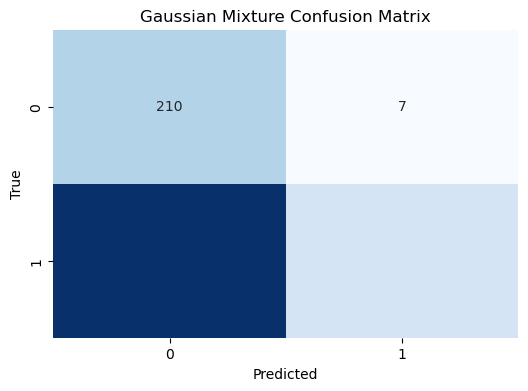

Accuracy: 0.33
Precision: 0.95


In [33]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(gmm_test_df['y'], gmm_test_df['y_hat'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gaussian Mixture Confusion Matrix')
plt.show()

# Evaluate K-means
gmm_accuracy = accuracy_score(test_data['travel_mode'], gmm_test_preds)
gmm_precision = precision_score(test_data['travel_mode'], gmm_test_preds)

print(f"Accuracy: {gmm_accuracy:.2f}")
print(f"Precision: {gmm_precision:.2f}")

- Both models were able to learn the high-level patterns of the data but not entirely satisfactory model 
accuracy. Both also have moderately high ability to project travel mode = 1 (by car) or True Positive. 
- The most prevalent difference between the two models is the ability to generalize the model. GMM’s 
capability of capturing non-spherical clusters (where kmean generally assumes spherical clusters with 
similar size) potentially enabled it to hand a wider range of distribution and thus the ability to deal with 
unseen data.
